In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import math

In [3]:
# Downscale thumbnails to 360p for training
img_size = (168, 94)

def loadImage(path):
	img = Image.open(path, 'r').convert('RGB').resize(img_size)
	# Convert colors from 0-255 to 0-1
	return np.asarray(img) / 255

In [4]:
# AI tries to match target values given source values
source = []
subs_src = []
target = []

# Import thumbnails from dataset/ folder
for img in os.listdir('dataset'):
	source.append(loadImage(f'dataset/{img}'))
	views, subs = img[12:-4].split("_")
	views_mag = len(views) - 1
	target.append(views_mag)
	subs_mag = len(subs) - 1
	subs_src.append(subs_mag)

# Convert to numpy arrays
source = np.array(source)
target = np.array(target)
subs_src = np.array(subs_src)
len(source)

1918

In [5]:
# x_train, x_valid, y_train, y_valid = train_test_split(source, subs_src, target, test_size=0.1)
# needed a train_test_split that does two things
train_to = int(len(source) / 10 * 8)
valid_from = train_to
valid_to = len(source)

x_train_p1 = np.array(source[0: train_to])
x_train_p2 = np.array(subs_src[0: train_to])
y_train = np.array(target[0: train_to])

x_train = [x_train_p1, x_train_p2]

x_valid_p1 = np.array(source[valid_from: valid_to])
x_valid_p2 = np.array(subs_src[valid_from: valid_to])
y_valid = np.array(target[valid_from: valid_to])

x_valid = [x_valid_p1, x_valid_p2]

In [71]:
i1 = keras.Input(shape=(img_size[1], img_size[0], 3), name="thumbnail")
x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='Same', activation='relu', name="feat_ext_1")(i1)
x = keras.layers.MaxPooling2D(pool_size=2, strides=2, name="pool_1")(x)
x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='Same', activation='relu', name="feat_ext_2")(x)
x = keras.layers.MaxPooling2D(pool_size=2, strides=2, name="pool_2")(x)
x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='Same', activation='relu', name="feat_ext_3")(x)
x = keras.layers.MaxPooling2D(pool_size=2, strides=2, name="pool_3")(x)
x = keras.layers.Flatten(name="flatten_1")(x)
x = keras.layers.Dropout(0.5, name="dropout_0.5")(x)
x = keras.layers.Dense(512, activation='relu', name="thumb_dense")(x)

i2 = keras.Input(shape=(1,), name="subs")
y = keras.layers.Dense(512, activation='relu', name="sub_expansion")(i2)

z = keras.layers.Concatenate(name="concat")([x, y])
z = keras.layers.Dense(512, activation='relu', name="concat_dense")(z)

output = keras.layers.Dense(10, activation='softmax', name="output")(z)
model = keras.Model(inputs=[i1, i2], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy())
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 thumbnail (InputLayer)         [(None, 94, 168, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 feat_ext_1 (Conv2D)            (None, 47, 84, 32)   2432        ['thumbnail[0][0]']              
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 23, 42, 32)   0           ['feat_ext_1[0][0]']             
                                                                                                  
 feat_ext_2 (Conv2D)            (None, 12, 21, 64)   51264       ['pool_1[0][0]']          

In [72]:
batch_size = 64
epochs = 64

history = model.fit(
	x_train, y_train,
	batch_size=batch_size,
	epochs=epochs,
	validation_data=(x_valid, y_valid)#,
	#steps_per_epoch=len(x_train) // batch_size # num_samples / batch_size
)

Epoch 1/64
24/24 [==============================] - 1s 22ms/step - loss: 1.8893 - val_loss: 1.6909
Epoch 2/64
24/24 [==============================] - 0s 11ms/step - loss: 1.6367 - val_loss: 1.6325
Epoch 3/64
24/24 [==============================] - 0s 10ms/step - loss: 1.6145 - val_loss: 1.6258
Epoch 4/64
24/24 [==============================] - 0s 11ms/step - loss: 1.6006 - val_loss: 1.6092
Epoch 5/64
24/24 [==============================] - 0s 12ms/step - loss: 1.5813 - val_loss: 1.5835
Epoch 6/64
24/24 [==============================] - 0s 10ms/step - loss: 1.5626 - val_loss: 1.5692
Epoch 7/64
24/24 [==============================] - 0s 10ms/step - loss: 1.5338 - val_loss: 1.5586
Epoch 8/64
24/24 [==============================] - 0s 11ms/step - loss: 1.5016 - val_loss: 1.5127
Epoch 9/64
24/24 [==============================] - 0s 13ms/step - loss: 1.4598 - val_loss: 1.4451
Epoch 10/64
24/24 [==============================] - 0s 11ms/step - loss: 1.4110 - val_loss: 1.4203
Epoch 11/

In [ ]:
model.save('model.tf') # TF is newer model format than H5

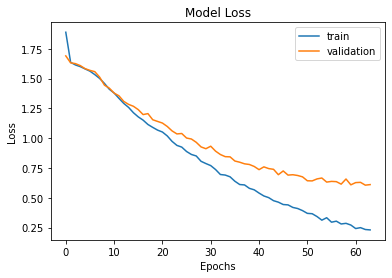

In [73]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "validation"])
plt.show()

12/12 [==============================] - 0s 6ms/step


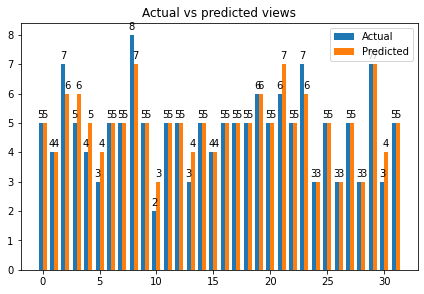

In [74]:
preds = model.predict(x_valid)
preds = np.argmax(preds, axis=1)
num_results = 32#len(preds)
width = 0.35
fig, ax = plt.subplots()
x = np.arange(num_results)
rects1 = ax.bar(x - width / 2, y_valid[:num_results], width, label='Actual')
rects2 = ax.bar(x + width / 2, preds[:num_results], width, label='Predicted')
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.title("Actual vs predicted views")
plt.show()

In [78]:
img = loadImage("maxresdefault.jpg")
thing1 = np.array([img])
thing2 = np.array([9])
np.argmax(model.predict([thing1, thing2]), axis=1)

1/1 [==============================] - 0s 19ms/step


array([7], dtype=int64)